# Model Scoping

## Claim:

In this analysis, I will be investigating the claim:

> *The cost per square foot is lower in duplexes than in single-family homes*

## Audience:

Our audience for this investigate is first-time home buyers.  We hope to give insight into what drives sales prices for first-time home buyers.

## Definitions:

For this analysis, we define the following as:

- Cost per square foot:  As defined by NAR and common practice amongst the real estate community, cost per square foot is defined as the sales price divided by the total living space square footage.  It does not include unfinished/finished basements, garages, porches etc.  For this analysis we will use the value in `SqFtTotLiving` from the Residential Building table to calculate the square footage and the `SalePrice` from the Real Property Sales table for the sale price. 
- Duplex:  Is defined as `Property Type` "Multiple family residence (Residential, 2-4 units)" (item 12 in lookup table).  `NbrLivingUnits` equal to '2' from the Residential building table.  (Zoning may also need to be LR1, LR2, LR3 or R-4 from `CurrentZoning` column in Parcel table).  
- Single-family home:  Is definited as `Property Type` "Household, single family units" (item 11 in lookup table).  `NbrLivingUnits` equal to '1'.  (Zoning may also need to be SF 5000, 7200, 9600).

## Feature Selection:

To investigate this claim, we will need the following features from the following tables:
- Sales Price of house:  `SalePrice` from rps table
- Living space square footage:  `SqFtTotLiving` from resbuild table
- Property Type:  `PropertyType` from rps table
- Number of units:  `NbrLivingUnits` from resbuild table
- Zoning codes:  `CurrentZoning` from parcel table

## The Process:

- First, I will define 2 data sets:  1 for duplexes and 1 for single family homes
- I will create new columns for each data set containing the price per square foot for each entry
- I will then create histograms/boxplots for each to get a feel for outliers for each group 
- Then I'll determine which outliers I can safely drop 
- I will generate means of the price per sf for each group and then perform a hypothesis t-test to test whether the mean cost per sf is lower for duplex's than single family units.  
- Then I'll create a model for both of the groups or just one of the groups?  **ask about this**

## Import data:

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn')
# from .src.data_cleaning import data_cleaning as dc

## figure out how to import and then I can delete function definitions here

In [10]:
def rps_2019_df():
    # load data
    rps = pd.read_csv("../data/EXTR_RPSale.csv")
    
    # change date to datetime object
    rps['DocumentDate'] = pd.to_datetime(rps['DocumentDate'])
    
    # create year column
    rps['year'] = rps['DocumentDate'].dt.year
    
    # create df of just 2019 entries    
    rps_2019 = rps[rps['year'] == 2019]
    
    # drop useless columns
    cols_to_drop = ['Volume', 'Page', 'PlatNbr', 'PlatType', 
                'PlatLot', 'PlatBlock', 'SellerName', 'BuyerName', 'year', 
                    'DocumentDate', 'RecordingNbr', 'AFForestLand', 'AFCurrentUseLand', 
                    'AFNonProfitUse', 'AFHistoricProperty', 'SaleReason', 'PropertyClass', 'SaleWarning']
    
    rps_2019.drop(columns = cols_to_drop, inplace = True)
    
        
    return rps_2019

#### Real Property Sales Table:

In [44]:
rps2019 = rps_2019_df()

/opt/anaconda3/envs/oy-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/opt/anaconda3/envs/oy-env/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [45]:
rps2019.head()

,ExciseTaxNbr,Major,Minor,SalePrice,PropertyType,PrincipalUse,SaleInstrument
4,3027422,213043,120,560000,11,6,3
118,2999169,919715,200,192000,3,2,3
144,3000673,894444,200,185000,3,2,3
164,3002257,940652,630,435000,11,6,3
445,2980836,937630,695,550000,3,6,3


In [46]:
rps2019['Major'] = rps2019['Major'].astype(str)

In [47]:
rps2019['Minor'] = rps2019['Minor'].astype(str)

#### Add Padding:

In [48]:
# pad major/minor
def major_pad(row):
    """
    This function takes an index item and pads it with 0's at the beginning
    to make it's total length equal to the pad_to value. 
    
    arguments:
    row (str):  item to add 0's infront of
    pad_to (int):  total length of padded item
    """
    num_zeros = 6 - len(row)
    return num_zeros * '0' + row

In [49]:
def minor_pad(row):
    """
    This function takes an index item and pads it with 0's at the beginning
    to make it's total length equal to the pad_to value. 
    
    arguments:
    row (str):  item to add 0's infront of
    pad_to (int):  total length of padded item
    """
    num_zeros = 4 - len(row)
    return num_zeros * '0' + row

In [50]:
rps2019['Major'] = rps2019['Major'].apply(major_pad)

In [51]:
rps2019['Minor'] = rps2019['Minor'].apply(minor_pad)

In [52]:
rps2019['maj_min'] = rps2019['Major'] + rps2019['Minor']

In [71]:
rps2019.drop(labels = ['Major', 'Minor'], axis = 1, inplace = True)

In [72]:
rps2019.head()

,ExciseTaxNbr,SalePrice,PropertyType,PrincipalUse,SaleInstrument,maj_min
4,3027422,560000,11,6,3,2130430120
118,2999169,192000,3,2,3,9197150200
144,3000673,185000,3,2,3,8944440200
164,3002257,435000,11,6,3,9406520630
445,2980836,550000,3,6,3,9376300695


In [83]:
rps2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61363 entries, 4 to 2089082
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ExciseTaxNbr    61363 non-null  int64 
 1   SalePrice       61363 non-null  int64 
 2   PropertyType    61363 non-null  int64 
 3   PrincipalUse    61363 non-null  int64 
 4   SaleInstrument  61363 non-null  int64 
 5   maj_min         61363 non-null  object
dtypes: int64(5), object(1)
memory usage: 3.3+ MB


#### Parcel Table:

In [34]:
# parcel df create:
parcel = pd.read_csv("../data/EXTR_Parcel.csv", usecols = ['Major', 'Minor', 'CurrentZoning'], encoding = 'latin-1')

parcel.head()

,Major,Minor,CurrentZoning
0,916110,346,SF 5000
1,132606,9228,R4.5
2,329870,12,SF 5000
3,884530,50,SF 5000
4,261730,220,RA5


In [35]:
parcel['Major'] = parcel['Major'].astype(str)

In [36]:
parcel['Minor'] = parcel['Minor'].astype(str)

#### Add Padding:

In [37]:
parcel['Major'] = parcel['Major'].apply(major_pad)

In [38]:
parcel['Minor'] = parcel['Minor'].apply(minor_pad)

In [54]:
parcel['maj_min'] = parcel['Major'] + parcel['Minor']

In [69]:
parcel.drop(labels = ['Major', 'Minor'], axis = 1, inplace = True)

In [70]:
parcel.head()

,CurrentZoning,maj_min
0,SF 5000,9161100346
1,R4.5,1326069228
2,SF 5000,3298700012
3,SF 5000,8845300050
4,RA5,2617300220


#### Residential Building Table:

In [56]:
# real property sales df create:
res_build = pd.read_csv("../data/EXTR_ResBldg.csv", usecols = ['Major', 'Minor', 
                                                               'SqFtTotLiving', 'NbrLivingUnits'])

res_build.head()

,Major,Minor,NbrLivingUnits,SqFtTotLiving
0,46100,935,1,960
1,46100,1165,1,3790
2,46100,1720,1,3470
3,46100,1745,1,2140
4,46100,1930,1,2240


In [57]:
res_build['Major'] = res_build['Major'].astype(str)

In [58]:
res_build['Minor'] = res_build['Minor'].astype(str)

#### Add Padding:

In [59]:
res_build['Major'] = res_build['Major'].apply(major_pad)

In [60]:
res_build['Minor'] = res_build['Minor'].apply(minor_pad)

In [61]:
res_build['maj_min'] = res_build['Major'] + res_build['Minor']

In [67]:
res_build.drop(labels = ['Major', 'Minor'], axis = 1, inplace = True)

In [68]:
res_build.head()

,NbrLivingUnits,SqFtTotLiving,maj_min
0,1,960,0461000935
1,1,3790,0461001165
2,1,3470,0461001720
3,1,2140,0461001745
4,1,2240,0461001930


### Merge Tables:

In [74]:
data = rps2019.merge(parcel, on = 'maj_min')

In [75]:
data.head()

,ExciseTaxNbr,SalePrice,PropertyType,PrincipalUse,SaleInstrument,maj_min,CurrentZoning
0,3027422,560000,11,6,3,2130430120,R4.5
1,3002257,435000,11,6,3,9406520630,R-6
2,2980836,550000,3,6,3,9376300695,RSL (M)
3,2975376,409950,11,6,3,0984000450,R6
4,2976405,380000,11,6,3,0302000645,R5


In [76]:
data = data.merge(res_build, on = 'maj_min')

In [77]:
data.head()

,ExciseTaxNbr,SalePrice,PropertyType,PrincipalUse,SaleInstrument,maj_min,CurrentZoning,NbrLivingUnits,SqFtTotLiving
0,3027422,560000,11,6,3,2130430120,R4.5,1,1930
1,3002257,435000,11,6,3,9406520630,R-6,1,1975
2,2980836,550000,3,6,3,9376300695,RSL (M),1,1560
3,2975376,409950,11,6,3,0984000450,R6,1,1850
4,2976405,380000,11,6,3,0302000645,R5,1,1750


In [78]:
data.set_index(keys = 'maj_min', inplace = True)

In [79]:
data.head()

,ExciseTaxNbr,SalePrice,PropertyType,PrincipalUse,SaleInstrument,CurrentZoning,NbrLivingUnits,SqFtTotLiving
maj_min,,,,,,,,
2130430120,3027422,560000,11,6,3,R4.5,1,1930
9406520630,3002257,435000,11,6,3,R-6,1,1975
9376300695,2980836,550000,3,6,3,RSL (M),1,1560
0984000450,2975376,409950,11,6,3,R6,1,1850
0302000645,2976405,380000,11,6,3,R5,1,1750


In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43867 entries, 2130430120 to 1923000170
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ExciseTaxNbr    43867 non-null  int64 
 1   SalePrice       43867 non-null  int64 
 2   PropertyType    43867 non-null  int64 
 3   PrincipalUse    43867 non-null  int64 
 4   SaleInstrument  43867 non-null  int64 
 5   CurrentZoning   43867 non-null  object
 6   NbrLivingUnits  43867 non-null  int64 
 7   SqFtTotLiving   43867 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 3.0+ MB


### Evaluate Current feature from data:

We have 43,867 entries after combining the three tables.  After reducing down to 2019 data from the Real Property Sales table, we had 61,363 entries.  **Think about why we lost data upon merging tables...**

## Filtering Data and Defining Data sets:

Now that we have all the relevant features in one dataframe, we can create a column with a boolean value that returns `True` if it is a duplex and `False` if it is a single family home.  We define these features as above.  

#### Defining Duplex and Single Family:

In [86]:
# define subset of data that is a duplex:
duplexes = data[(data['PropertyType'] == 12) & (data['NbrLivingUnits'] == 2)]
duplexes.shape

(135, 8)

So, we have 135 duplexes in our data set.

In [87]:
# define subset of data that is a single family home:
singlefam = data[(data['PropertyType'] == 11) & (data['NbrLivingUnits'] == 1)]
singlefam.shape

(26101, 8)

In [90]:
# define dataframe with just single family and duplex entries:
duplex_sf = data[((data['PropertyType'] == 11) & (data['NbrLivingUnits'] == 1)) \
     | ((data['PropertyType'] == 12) & (data['NbrLivingUnits'] == 2))]

In [91]:
duplex_sf.head()

,ExciseTaxNbr,SalePrice,PropertyType,PrincipalUse,SaleInstrument,CurrentZoning,NbrLivingUnits,SqFtTotLiving
maj_min,,,,,,,,
2130430120,3027422,560000,11,6,3,R4.5,1,1930
9406520630,3002257,435000,11,6,3,R-6,1,1975
0984000450,2975376,409950,11,6,3,R6,1,1850
0302000645,2976405,380000,11,6,3,R5,1,1750
7797900030,3015516,0,11,6,3,SF 5000,1,890


In [92]:
duplex_sf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26236 entries, 2130430120 to 1923000170
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ExciseTaxNbr    26236 non-null  int64 
 1   SalePrice       26236 non-null  int64 
 2   PropertyType    26236 non-null  int64 
 3   PrincipalUse    26236 non-null  int64 
 4   SaleInstrument  26236 non-null  int64 
 5   CurrentZoning   26236 non-null  object
 6   NbrLivingUnits  26236 non-null  int64 
 7   SqFtTotLiving   26236 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 1.8+ MB


### Create bool column for is_duplex:

In [103]:
duplex_sf['is_duplex'] = (duplex_sf.PropertyType == 12) & (duplex_sf.NbrLivingUnits == 2)
        
duplex_sf.head()

<ipython-input-103-39ed54bf8171>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplex_sf['is_duplex'] = (duplex_sf.PropertyType == 12) & (duplex_sf.NbrLivingUnits == 2)


,ExciseTaxNbr,SalePrice,PropertyType,PrincipalUse,SaleInstrument,CurrentZoning,NbrLivingUnits,SqFtTotLiving,is_duplex
maj_min,,,,,,,,,
2130430120,3027422,560000,11,6,3,R4.5,1,1930,False
9406520630,3002257,435000,11,6,3,R-6,1,1975,False
0984000450,2975376,409950,11,6,3,R6,1,1850,False
0302000645,2976405,380000,11,6,3,R5,1,1750,False
7797900030,3015516,0,11,6,3,SF 5000,1,890,False
6154900010,3012934,775000,11,6,3,SF 7200,1,2080,False
1238500905,2972483,0,11,6,15,RSX 7.2,1,2990,False
5029400090,2998941,0,11,6,15,R6,1,880,False
5029400090,2998942,0,11,6,15,R6,1,880,False


In [104]:
duplex_sf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26236 entries, 2130430120 to 1923000170
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ExciseTaxNbr    26236 non-null  int64 
 1   SalePrice       26236 non-null  int64 
 2   PropertyType    26236 non-null  int64 
 3   PrincipalUse    26236 non-null  int64 
 4   SaleInstrument  26236 non-null  int64 
 5   CurrentZoning   26236 non-null  object
 6   NbrLivingUnits  26236 non-null  int64 
 7   SqFtTotLiving   26236 non-null  int64 
 8   is_duplex       26236 non-null  bool  
dtypes: bool(1), int64(7), object(1)
memory usage: 2.5+ MB


You can see we've kept all our data and if we sum the `is_duplex` column, it should amount to `135` to show all our 135 duplexes we found earlier:

In [105]:
duplex_sf['is_duplex'].sum()

135

Bingo.

### Create Price/SF column:

In [107]:
# price/sf is defined as SalePrice/SqFtTotLiving
duplex_sf['price_per_sf'] = duplex_sf['SalePrice'] / duplex_sf['SqFtTotLiving']
duplex_sf.head()

<ipython-input-107-415db64466db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplex_sf['price_per_sf'] = duplex_sf['SalePrice'] / duplex_sf['SqFtTotLiving']


,ExciseTaxNbr,SalePrice,PropertyType,PrincipalUse,SaleInstrument,CurrentZoning,NbrLivingUnits,SqFtTotLiving,is_duplex,price_per_sf
maj_min,,,,,,,,,,
2130430120,3027422,560000,11,6,3,R4.5,1,1930,False,290.155440
9406520630,3002257,435000,11,6,3,R-6,1,1975,False,220.253165
0984000450,2975376,409950,11,6,3,R6,1,1850,False,221.594595
0302000645,2976405,380000,11,6,3,R5,1,1750,False,217.142857
7797900030,3015516,0,11,6,3,SF 5000,1,890,False,0.000000


In [108]:
duplex_sf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26236 entries, 2130430120 to 1923000170
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ExciseTaxNbr    26236 non-null  int64  
 1   SalePrice       26236 non-null  int64  
 2   PropertyType    26236 non-null  int64  
 3   PrincipalUse    26236 non-null  int64  
 4   SaleInstrument  26236 non-null  int64  
 5   CurrentZoning   26236 non-null  object 
 6   NbrLivingUnits  26236 non-null  int64  
 7   SqFtTotLiving   26236 non-null  int64  
 8   is_duplex       26236 non-null  bool   
 9   price_per_sf    26236 non-null  float64
dtypes: bool(1), float64(1), int64(7), object(1)
memory usage: 2.7+ MB


## Visualise the Data:

In [110]:
# view summary of SalePrice and price_per_sf
duplex_sf.describe()

,ExciseTaxNbr,SalePrice,PropertyType,PrincipalUse,SaleInstrument,NbrLivingUnits,SqFtTotLiving,price_per_sf
count,2.623600e+04,2.623600e+04,26236.000000,26236.000000,26236.000000,26236.000000,26236.000000,26236.000000
mean,2.999282e+06,5.635347e+05,11.005146,5.999962,5.928571,1.005146,2140.162982,278.377188
std,1.739472e+04,6.155587e+05,0.071549,0.026911,5.403851,0.071549,987.187026,762.258186
min,2.968804e+06,0.000000e+00,11.000000,2.000000,2.000000,1.000000,2.000000,0.000000
25%,2.982886e+06,0.000000e+00,11.000000,6.000000,3.000000,1.000000,1440.000000,0.000000
50%,2.999780e+06,5.000000e+05,11.000000,6.000000,3.000000,1.000000,1960.000000,273.117122
75%,3.013042e+06,7.890000e+05,11.000000,6.000000,3.000000,1.000000,2620.000000,408.653846
max,3.051203e+06,1.605000e+07,12.000000,7.000000,27.000000,2.000000,10910.000000,115000.000000


(-802500.0, 16852500.0)

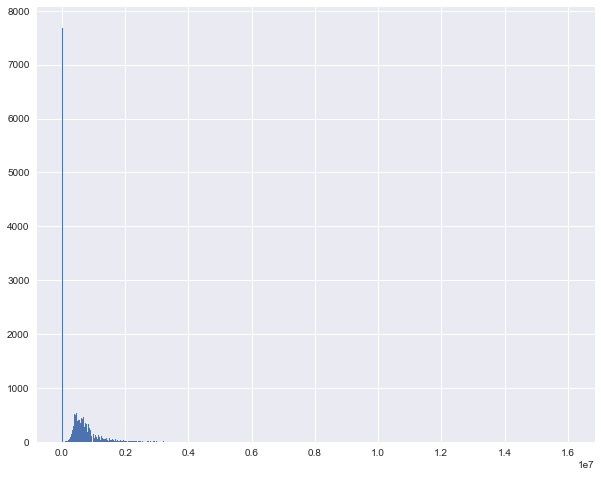

In [126]:
# plot SalePrice data:
duplex_sf.SalePrice.hist(figsize=(10,8), bins = 1000)
plt.xlim()

## CHANGE X/Y SCALES!!

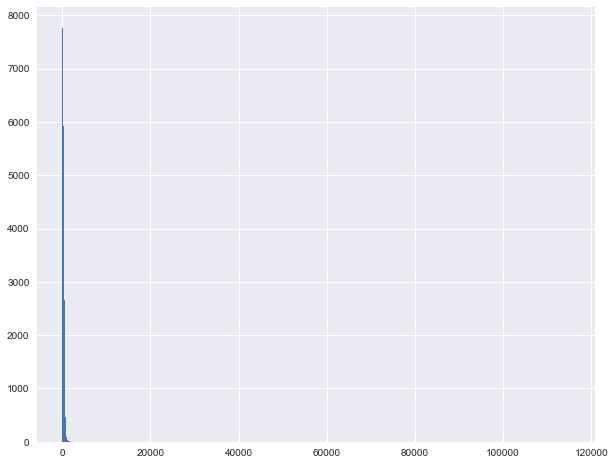

In [125]:
# plot price_per_sf data:
duplex_sf.price_per_sf.hist(figsize=(10,8), bins = 1000)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,15), sharey=True)

for ax, column in zip(axes.flatten(), data.columns):
    ax.scatter(data[column], data['SalePrice'] / 100_000, label=column, alpha=.1)
    ax.set_title(f'Sale Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Sale Price in $100,000')

fig.tight_layout()

### Create First Shitty Model:

In [127]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [131]:
# create x, y variables to find potential correlations:

X = duplex_sf
y = data['SalePrice']

In [132]:
# create correlation matrix:
corr_x = X.corr()
corr_x

,ExciseTaxNbr,SalePrice,PropertyType,PrincipalUse,SaleInstrument,NbrLivingUnits,SqFtTotLiving,is_duplex,price_per_sf
ExciseTaxNbr,1.000000,0.014124,-0.012421,-0.006122,-0.018018,-0.012421,0.006870,-0.012421,-0.004077
SalePrice,0.014124,1.000000,-0.027303,0.009487,-0.490858,-0.027303,0.420863,-0.027303,0.242970
PropertyType,-0.012421,-0.027303,1.000000,0.000102,0.034371,1.000000,-0.007395,1.000000,-0.010151
PrincipalUse,-0.006122,0.009487,0.000102,1.000000,-0.011814,0.000102,-0.015082,0.000102,0.004000
SaleInstrument,-0.018018,-0.490858,0.034371,-0.011814,1.000000,0.034371,-0.016578,0.034371,-0.195967
NbrLivingUnits,-0.012421,-0.027303,1.000000,0.000102,0.034371,1.000000,-0.007395,1.000000,-0.010151
SqFtTotLiving,0.006870,0.420863,-0.007395,-0.015082,-0.016578,-0.007395,1.000000,-0.007395,-0.042843
is_duplex,-0.012421,-0.027303,1.000000,0.000102,0.034371,1.000000,-0.007395,1.000000,-0.010151
price_per_sf,-0.004077,0.242970,-0.010151,0.004000,-0.195967,-0.010151,-0.042843,-0.010151,1.000000


In [ ]:
# set up model:
f = 'SalePrice ~ T' 
model = ols(formula = f, data = data).fit()